In [1]:
import sys; sys.path.append('..')
from src.models.feat_vae import FeatVAE
from src.models.classifier import FeatClassifier
from src.dataloaders.load_data import load_data
from firelab.config import Config

DEVICE = 'cpu'

In [2]:
config = Config.load('../configs/lat_gm_vae.yml', frozen=False)
config.all.hp.model.set('pretrained', True)
config.all.hp.model.set('num_classes', 200)
# config = config.overwrite(Config({'all': {'hp': {'model': {'learn_prior' : True}}}}))
config.all.hp.model.learn_prior = True
base_conf = Config.load('../configs/base.yml')
base_conf = base_conf.overwrite(Config({'cub_embedded': {'data': {'dir': "../data/CUB_EMBEDDED"}}}))

In [3]:
from torch.utils.data import DataLoader

train_ds, test_ds, attrs = load_data(base_conf.cub_embedded.data)
train_dataloader = DataLoader(train_ds, batch_size=256, shuffle=True, collate_fn=lambda b: list(zip(*b)))
test_dataloader = DataLoader(test_ds, batch_size=256, shuffle=False, collate_fn=lambda b: list(zip(*b)))

Loading train_feats_resnet18.npy
Loading test_feats_resnet18.npy


In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from src.utils.losses import compute_kld_between_diagonal_gaussians as compute_kl_loss


def validate_vae(vae_model, dataloader):
    rec_losses = []
    kl_losses = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            z_mean, z_logvar = vae_model.encoder(x, y)
            z_prior_mean, z_prior_logvar = vae_model.prior(y)
            z = vae_model.sample(z_mean, z_logvar)
            x_rec = vae_model.decoder(z, y)

            rec_loss = F.mse_loss(x_rec, x, reduction='none').mean(dim=1)
            kl_loss = compute_kl_loss(z_mean, z_logvar, z_prior_mean, z_prior_logvar, reduction=None)

            rec_losses.extend(rec_loss.cpu().tolist())
            kl_losses.extend(kl_loss.cpu().tolist())

    return np.mean(rec_losses), np.mean(kl_losses)

In [8]:
# config = config.overwrite(Config({'all': {'hp': {'model': {'z_dim' : 512}}}}))
vae = FeatVAE(config.all.hp.model).to(DEVICE)

In [9]:
optim = torch.optim.Adam(vae.parameters(), lr=1e-4)
max_num_epochs = 50
beta = 1.
train_rec_loss_history = []
train_kl_loss_history = []


for epoch in range(max_num_epochs):
    for x, y in train_dataloader:
        x = torch.tensor(x).to(DEVICE)
        y = torch.tensor(y).to(DEVICE)
        
        z_mean, z_logvar = vae.encoder(x, y)
        z_prior_mean, z_prior_logvar = vae.prior(y)
        z = vae.sample(z_mean, z_logvar, noise_level=epoch/max_num_epochs)
        x_rec = vae.decoder(z, y)
        
        rec_loss = F.mse_loss(x_rec, x)
        kl_loss = compute_kl_loss(z_mean, z_logvar, z_prior_mean, z_prior_logvar)

        total_loss = rec_loss + beta * kl_loss
        
        optim.zero_grad()
        total_loss.backward()
        optim.step()
    
    val_rec_loss, val_kl_loss = validate_vae(vae, test_dataloader)
    
    if epoch % 5 == 0:
        print(f'[Epoch #{epoch:03d}] Train rec loss: {rec_loss.item(): 0.4f}. Train KL loss: {kl_loss.item(): 0.4f}')
        print(f'[Epoch #{epoch:03d}] Val rec loss  : {val_rec_loss.item(): 0.4f}. Val KL loss  : {val_kl_loss.item(): 0.4f}')

[Epoch #000] Train rec loss:  0.3362. Train KL loss:  9.4596
[Epoch #000] Val rec loss  :  0.2817. Val KL loss  :  9.0377
[Epoch #005] Train rec loss:  0.1239. Train KL loss:  1.0358
[Epoch #005] Val rec loss  :  0.1763. Val KL loss  :  1.0119
[Epoch #010] Train rec loss:  0.1159. Train KL loss:  0.2333
[Epoch #010] Val rec loss  :  0.1612. Val KL loss  :  0.2345
[Epoch #015] Train rec loss:  0.1166. Train KL loss:  0.0853
[Epoch #015] Val rec loss  :  0.1469. Val KL loss  :  0.0882
[Epoch #020] Train rec loss:  0.1153. Train KL loss:  0.0428
[Epoch #020] Val rec loss  :  0.1351. Val KL loss  :  0.0443
[Epoch #025] Train rec loss:  0.1054. Train KL loss:  0.0241
[Epoch #025] Val rec loss  :  0.1263. Val KL loss  :  0.0269
[Epoch #030] Train rec loss:  0.1003. Train KL loss:  0.0163
[Epoch #030] Val rec loss  :  0.1204. Val KL loss  :  0.0185
[Epoch #035] Train rec loss:  0.1149. Train KL loss:  0.0121
[Epoch #035] Val rec loss  :  0.1159. Val KL loss  :  0.0139
[Epoch #040] Train rec l

In [66]:
import torch.nn.functional as F
from src.models.feat_gan import FeatGenerator, FeatDiscriminator

gan_config = Config.load('../configs/lat_gm.yml', frozen=False)
gan_config.all.hp.model.set('pretrained', True)
gan_config.all.hp.model.set('num_classes', 200)
gan_config.all.hp.model.use_attrs_in_gen = False
gan_config.all.hp.model.use_attrs_in_discr = False
gan_config.all.hp.model.cls_hid_dim = 1024
gan_config.all.hp.model.share_body_in_discr = True

gen = FeatGenerator(gan_config.all.hp.model)
discr = FeatDiscriminator(gan_config.all.hp.model)

def generator_step(gen, discr, optim_gen, x, y, cls_gen_coef:float=1.):
    z = gen.sample_noise(y.size(0)).to(DEVICE)
    x_fake = gen(z, y)
    adv_logits, cls_logits = discr(x_fake)
    adv_loss = -adv_logits.mean()
    cls_loss = F.cross_entropy(cls_logits, y)
    cls_acc = (cls_logits.argmax(dim=1) == y).float().mean().detach().cpu()
    
    total_loss = adv_loss + cls_gen_coef * cls_loss
    
    optim_gen.zero_grad()
    total_loss.backward()
    optim_gen.step()
    
    return adv_loss, cls_acc
    
    
def discriminator_step(gen, discr, optim_discr, x, y, gp_coef:float=10.,
                       cls_discr_coef:float=1., cls_adv_loss_coef:float=1.):
    with torch.no_grad():
        z = gen.sample_noise(y.size(0)).to(DEVICE)
        x_fake = gen(z, y) # TODO: try picking y randomly

    adv_logits_on_real, cls_logits_on_real = discr(x)
    adv_logits_on_fake, cls_logits_on_fake = discr(x_fake)

    adv_loss = -adv_logits_on_real.mean() + adv_logits_on_fake.mean()
    grad_penalty = compute_gradient_penalty(discr.run_adv_head, x, x_fake)
    
    cls_loss = F.cross_entropy(cls_logits_on_real, y)
    cls_acc = (cls_logits_on_real.argmax(dim=1) == y).float().mean().detach().cpu()
    
    # Cross-entropy with uniform dist
    #cls_adv_loss = -((cls_logits_on_fake.sum(dim=1) - cls_logits_on_fake.logsumexp(dim=1)) \
    #                    / cls_logits_on_fake.shape[1]).mean()
    cls_adv_loss = F.kl_div(cls_logits_on_fake.log_softmax(dim=1), torch.ones_like(cls_logits_on_fake) / cls_logits_on_fake.shape[1])
    if cls_adv_loss.abs() > 100:
        cls_adv_loss = (cls_adv_loss / cls_adv_loss.abs().detach()) * 100

    total_loss = adv_loss + gp_coef * grad_penalty + cls_discr_coef * cls_loss + cls_adv_loss_coef * cls_adv_loss
    
    optim_discr.zero_grad()
    total_loss.backward()
    optim_discr.step()

    return adv_loss, grad_penalty, cls_acc, cls_adv_loss

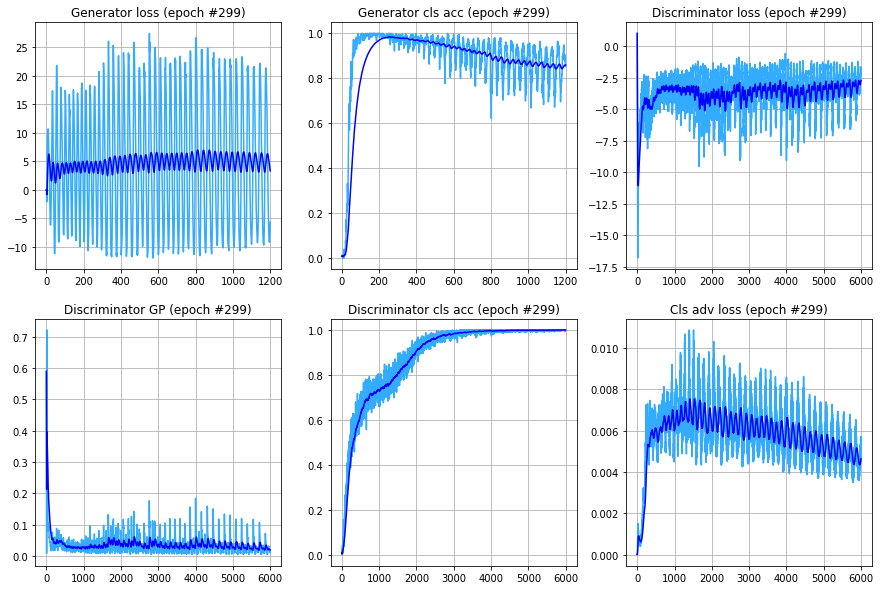

In [67]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline

from src.utils.losses import compute_gradient_penalty

optim_gen = torch.optim.Adam(gen.parameters())
optim_discr = torch.optim.Adam(discr.parameters())
max_num_epochs = 300
num_discr_steps = 5


num_iters_done = 0
gen_adv_losses_hist = []
gen_cls_acc_hist = []
discr_adv_losses_hist = []
gp_hist = []
discr_cls_acc_hist = []
cls_adv_loss_hist = []
plot_every_epoch = 1


for epoch in range(max_num_epochs):
    for x, y in train_dataloader:
        x = torch.tensor(x).to(DEVICE)
        y = torch.tensor(y).to(DEVICE)
        
        if num_iters_done % (num_discr_steps + 1) == 0:
            gen_adv_loss, gen_cls_acc = generator_step(
                gen, discr, optim_gen, x, y)
            
            gen_adv_losses_hist.append(gen_adv_loss.detach().cpu().item())
            gen_cls_acc_hist.append(gen_cls_acc.item())
        else:
            discr_adv_loss, grad_penalty, discr_cls_acc, cls_adv_loss = discriminator_step(
                gen, discr, optim_discr, x, y, cls_discr_coef=5., cls_adv_loss_coef=500.)
            
            discr_adv_losses_hist.append(discr_adv_loss.detach().cpu().item())
            gp_hist.append(grad_penalty.detach().cpu().item())
            discr_cls_acc_hist.append(discr_cls_acc.item())
            cls_adv_loss_hist.append(cls_adv_loss.detach().cpu().item())
            
        num_iters_done += 1
            
    if epoch % plot_every_epoch == 0:
        clear_output(True)
        plt.figure(figsize=[15,10])

        plt.subplot(231)
        plt.title(f"Generator loss (epoch #{epoch})")
        plt.plot(gen_adv_losses_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(gen_adv_losses_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(232)
        plt.title(f"Generator cls acc (epoch #{epoch})")
        plt.plot(gen_cls_acc_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(gen_cls_acc_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()

        plt.subplot(233)
        plt.title(f"Discriminator loss (epoch #{epoch})")
        plt.plot(discr_adv_losses_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(discr_adv_losses_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()

        plt.subplot(234)
        plt.title(f"Discriminator GP (epoch #{epoch})")
        plt.plot(gp_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(gp_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(235)
        plt.title(f"Discriminator cls acc (epoch #{epoch})")
        plt.plot(discr_cls_acc_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(discr_cls_acc_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()
        
        plt.subplot(236)
        plt.title(f"Cls adv loss (epoch #{epoch})")
        plt.plot(cls_adv_loss_hist, color='#33ACFF')
        plt.plot(pd.DataFrame(cls_adv_loss_hist).ewm(span=100).mean(), color='#0000FF')
        plt.grid()

        plt.show()

In [68]:
def validate_clf(clf_model, dataloader):
    losses = []
    accs = []

    with torch.no_grad():
        for x, y in dataloader:
            x = torch.tensor(x).to(DEVICE)
            y = torch.tensor(y).to(DEVICE)

            logits = clf_model(x)
            loss = F.cross_entropy(logits, y, reduction='none')
            acc = (logits.argmax(dim=1) == y).float().cpu().detach().tolist()
            
            losses.extend(loss)
            accs.extend(acc)
        
    return np.mean(losses), np.mean(accs)

In [69]:
import random

clf = FeatClassifier(config.all.hp.model).to(DEVICE)
optim = torch.optim.Adam(clf.parameters(), lr=1e-3)
max_num_steps = 1000
batch_size = 256

for step in range(max_num_steps):
    with torch.no_grad():
        y = random.choices(range(200), k=batch_size)
        y = torch.tensor(y).to(DEVICE)
        x = gen.sample(y)
        
    logits = clf(x)
    loss = F.cross_entropy(logits, y)
    acc = (logits.argmax(dim=1) == y).float().mean().cpu().detach()
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if step % 100 == 0:
        val_loss, val_acc = validate_clf(clf, test_dataloader)

        print(f'[Step #{step:04d}] Train loss: {loss.item(): 0.4f}. Train acc: {acc.item(): 0.4f}')
        print(f'[Step #{step:04d}] Val loss  : {val_loss.item(): 0.4f}. Val acc  : {val_acc.item(): 0.4f}')

[Step #0000] Train loss:  5.3261. Train acc:  0.0000
[Step #0000] Val loss  :  5.3022. Val acc  :  0.0066
[Step #0100] Train loss:  0.0254. Train acc:  1.0000
[Step #0100] Val loss  :  4.5261. Val acc  :  0.1111
[Step #0200] Train loss:  0.0069. Train acc:  1.0000
[Step #0200] Val loss  :  4.4563. Val acc  :  0.1319
[Step #0300] Train loss:  0.0040. Train acc:  1.0000
[Step #0300] Val loss  :  4.4446. Val acc  :  0.1379
[Step #0400] Train loss:  0.0019. Train acc:  1.0000
[Step #0400] Val loss  :  4.4562. Val acc  :  0.1422
[Step #0500] Train loss:  0.0016. Train acc:  1.0000
[Step #0500] Val loss  :  4.4769. Val acc  :  0.1424
[Step #0600] Train loss:  0.0011. Train acc:  1.0000
[Step #0600] Val loss  :  4.5048. Val acc  :  0.1420
[Step #0700] Train loss:  0.0008. Train acc:  1.0000
[Step #0700] Val loss  :  4.5257. Val acc  :  0.1429
[Step #0800] Train loss:  0.0007. Train acc:  1.0000
[Step #0800] Val loss  :  4.5494. Val acc  :  0.1422
[Step #0900] Train loss:  0.0005. Train acc:  

In [10]:
vae.prior.model(torch.randn(256, 512))

tensor([[-0.0595,  0.0843,  0.1494,  ..., -0.0279,  0.0350,  0.1876],
        [ 0.2109,  0.2832,  0.2442,  ..., -0.1384,  0.0499,  0.2831],
        [-0.0986,  0.1802,  0.2164,  ..., -0.2871,  0.0885,  0.2140],
        ...,
        [-0.0395,  0.2444,  0.2044,  ..., -0.1277, -0.0568, -0.0962],
        [ 0.0524,  0.0608,  0.0425,  ...,  0.1806,  0.1132,  0.0754],
        [ 0.4461,  0.2793,  0.2740,  ...,  0.1276, -0.0822, -0.1154]],
       grad_fn=<AddmmBackward>)

In [9]:
vae.prior.model(vae.prior.embedder(y))

tensor([[-0.0099, -0.0249, -0.0104,  ...,  0.0355,  0.0128,  0.0184],
        [-0.0099, -0.0249, -0.0104,  ...,  0.0355,  0.0128,  0.0184],
        [-0.0099, -0.0249, -0.0104,  ...,  0.0355,  0.0128,  0.0184],
        ...,
        [-0.0099, -0.0249, -0.0104,  ...,  0.0355,  0.0128,  0.0184],
        [-0.0099, -0.0249, -0.0104,  ...,  0.0355,  0.0128,  0.0184],
        [-0.0099, -0.0249, -0.0104,  ...,  0.0355,  0.0128,  0.0184]],
       grad_fn=<AddmmBackward>)

In [35]:
import random

clf = FeatClassifier(config.all.hp.model).to(DEVICE)
optim = torch.optim.Adam(clf.parameters(), lr=1e-3)
max_num_epochs = 100

for epoch in range(max_num_epochs):
    for x, y in train_dataloader:
        x = torch.tensor(x).to(DEVICE)
        y = torch.tensor(y).to(DEVICE)

        logits = clf(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean().cpu().detach()

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    if epoch % 1 == 0:
        val_loss, val_acc = validate_clf(clf, test_dataloader)
        
        print(f'[Step #{epoch:04d}] Train loss: {loss.item(): 0.4f}. Train acc: {acc.item(): 0.4f}')
        print(f'[Step #{epoch:04d}] Val loss  : {val_loss.item(): 0.4f}. Val acc  : {val_acc.item(): 0.4f}')

[Step #0000] Train loss:  5.0316. Train acc:  0.0283
[Step #0000] Val loss  :  4.9438. Val acc  :  0.0751
[Step #0010] Train loss:  1.8723. Train acc:  0.5377
[Step #0010] Val loss  :  2.3112. Val acc  :  0.4154
[Step #0020] Train loss:  1.1081. Train acc:  0.7170
[Step #0020] Val loss  :  1.9765. Val acc  :  0.4727
[Step #0030] Train loss:  0.8228. Train acc:  0.8113
[Step #0030] Val loss  :  1.9072. Val acc  :  0.4967
[Step #0040] Train loss:  0.4386. Train acc:  0.9151
[Step #0040] Val loss  :  1.9606. Val acc  :  0.5054
[Step #0050] Train loss:  0.3206. Train acc:  0.9340
[Step #0050] Val loss  :  2.0314. Val acc  :  0.5066
[Step #0060] Train loss:  0.1743. Train acc:  1.0000
[Step #0060] Val loss  :  2.1084. Val acc  :  0.5014
[Step #0070] Train loss:  0.1036. Train acc:  1.0000
[Step #0070] Val loss  :  2.1963. Val acc  :  0.5074
[Step #0080] Train loss:  0.0716. Train acc:  1.0000
[Step #0080] Val loss  :  2.2857. Val acc  :  0.5055
[Step #0090] Train loss:  0.0509. Train acc:  